In [28]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [29]:
%matplotlib inline

import sys
import os

from IPython.display import display
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt 
from optparse import OptionParser
import numpy as np
import cv2
import math
import logging

get_ipython().magic(u'matplotlib inline')

In [30]:
# set up logging options
logger = logging.getLogger()
logger.propagate = False

print(str(len(logger.handlers)) + ' handlers are available for logging. removing extra handlers if needed!')
for handler in logger.handlers:
    logger.handlers.remove(handler)

# create a file handler
handler = logging.FileHandler('assignment4.log', mode='w')
handler.setLevel(logging.DEBUG)
# add the handlers to the logger
logger.addHandler(handler)
  
# add stream handler
ch = logging.StreamHandler(sys.stdout)
logger.setLevel(logging.INFO)
logger.addHandler(ch)

logger.handlers

3 handlers are available for logging. removing extra handlers if needed!


# Space Invariant blurring (Mantrilla.pgm)

In [31]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

def getNormalizedBlurKernel(sigma):
    #logger.info('sigma = ' + str(sigma))
    actualBlurWidth = int(math.ceil(6 * sigma + 1))
    if(actualBlurWidth % 2 == 0) : 
        actualBlurWidth = actualBlurWidth + 1
        
    halfBlurWidth = int(math.floor(actualBlurWidth / 2))
    blurKernel = np.zeros([actualBlurWidth, actualBlurWidth])
    #logger.info('half blur width = ' + str(halfBlurWidth))

    # range (start, stop)
    for i in range(-halfBlurWidth, halfBlurWidth + 1):
        rowIndex = i + halfBlurWidth

        for j in range(-halfBlurWidth, halfBlurWidth + 1):
            columnIndex = j + halfBlurWidth
            if(sigma == 0):
                blurKernel[rowIndex, columnIndex] = 1;
            else:
                blurKernel[rowIndex, columnIndex] = (math.exp(-(((i * i) + (j * j)) / (2 * (sigma * sigma)))) /
                                                         (2 * math.pi * (sigma * sigma)))
                
    blurKernel = blurKernel / (np.sum(blurKernel))
    return blurKernel


In [32]:
def getRecepFieldAndKernelIndices(i, j, imgWidth, imgHeight, kernelWidth, kernelHeight):
    halfKernelWidth = int(math.floor(kernelWidth / 2))
    
    startRecepRowIndex = 0
    startImgRowIndex = i - halfKernelWidth
    endRecepRowIndex = kernelWidth - 1
    endImgRowIndex = i + halfKernelWidth
    startRecepColumnIndex = 0
    startImgColumnIndex = j - halfKernelWidth
    endRecepColumnIndex = kernelHeight - 1
    endImgColumnIndex = j + halfKernelWidth

    if(startImgRowIndex < 0):
        startRecepRowIndex = -startImgRowIndex
        startImgRowIndex = 0
    if(endImgRowIndex >= imgHeight):
        endRecepRowIndex = endRecepRowIndex - (endImgRowIndex - imgHeight + 1)
        endImgRowIndex = imgHeight - 1
    if(startImgColumnIndex < 0):
        startRecepColumnIndex = -startImgColumnIndex                
        startImgColumnIndex = 0
    if(endImgColumnIndex >= imgWidth):
        endRecepColumnIndex = endRecepColumnIndex - (endImgColumnIndex - imgWidth + 1)
        endImgColumnIndex = imgWidth - 1                

    return startRecepRowIndex, endRecepRowIndex, startRecepColumnIndex, endRecepColumnIndex, \
            startImgRowIndex, endImgRowIndex, startImgColumnIndex, endImgColumnIndex

In [33]:
def getNeighborhood(img, i, j, neighboorhoodWidth):
    imgWidth, imgHeight = img.shape
    kernelWidth = neighboorhoodWidth
    kernelHeight = neighboorhoodWidth
    receptiveField = np.zeros([neighboorhoodWidth, neighboorhoodWidth])

    startRecepRowIndex, endRecepRowIndex, startRecepColumnIndex, endRecepColumnIndex, \
    startImgRowIndex, endImgRowIndex, startImgColumnIndex, endImgColumnIndex  \
            = getRecepFieldAndKernelIndices(i, j, imgWidth, imgHeight, kernelWidth, kernelHeight)

    receptiveField[startRecepRowIndex:endRecepRowIndex+1, startRecepColumnIndex:endRecepColumnIndex+1] = \
                img[startImgRowIndex:endImgRowIndex+1, startImgColumnIndex:endImgColumnIndex+1]
    
    return receptiveField


In [34]:
def convolve(img, kernel):
    imgWidth, imgHeight = img.shape
    kernelWidth, kernelHeight = kernel.shape
    convolvedImg = np.zeros([imgWidth, imgHeight])
    
    for i in range(imgWidth):
        for j in range(imgHeight):
            # fix the kernel at i, j and convolve the kernel 
            receptiveField = getNeighborhood(img, i, j, kernelHeight)
            convolvedImg[i, j] = np.sum(receptiveField * kernel)
            
    return convolvedImg

In [35]:
def doSpaceInvariantBlurring(img, sigma):
    blurkernel = getNormalizedBlurKernel(sigma)
    blurredImage = convolve(img, blurkernel)
    return blurredImage

In [36]:
def showImage(img, caption):
    display(caption)
    plt.figure()
    plt.axis('off')
    imshow(img, cmap='gray')
    plt.show()

'Original image'

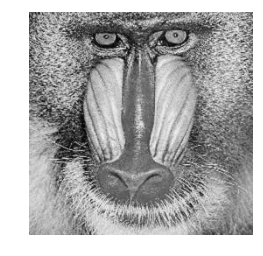

'sigma = 0.0'

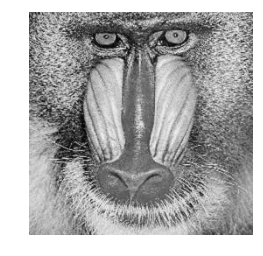

'sigma = 0.3'

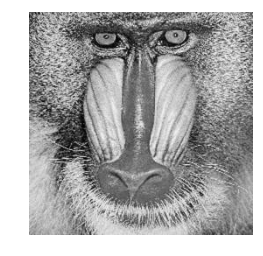

'sigma = 0.6'

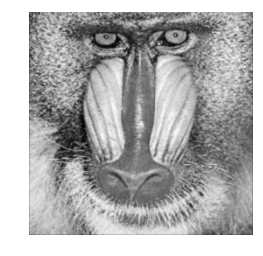

'sigma = 1.0'

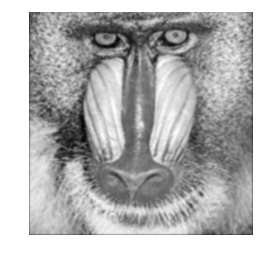

'sigma = 1.2'

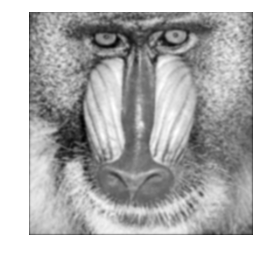

'sigma = 1.6'

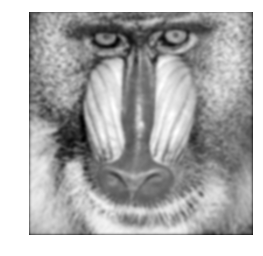

In [37]:
# read the images
mandrillFile = 'Mandrill'
globeFile = 'Globe'
nautilusFile = 'Nautilus'
mandrill = cv2.imread('./Lab4/' + mandrillFile + '.pgm', 0)
globe = cv2.imread('./Lab4/' + globeFile + '.pgm', 0)
nautilus = cv2.imread('./Lab4/' + nautilusFile + '.pgm', 0)

kernelSigmas = [1.6, 1.2, 1.0, 0.6, 0.3, 0.0] #
kernelSigmas = np.flipud(kernelSigmas)
from scipy.misc import toimage

cv2.imwrite('./output/' + mandrillFile + '-original.pgm', mandrill)
showImage(mandrill, 'Original image')
for sigma in kernelSigmas:
    blurredImage = doSpaceInvariantBlurring(mandrill, sigma)
    cv2.imwrite('./output/' + mandrillFile + '-' + str(sigma) + '.pgm', blurredImage)   
    showImage(blurredImage, 'sigma = ' + str(sigma))
    

# Space variant blurring (Globe.pgm)

After solving the equation, 

A = 2,

B = N^2 / log_e(200)

In [38]:
def getSigmaMatrix(img):
    imgHeight, imgWidth = img.shape
    sigma = np.zeros([imgHeight, imgWidth])
    N = imgHeight
    
    # determined constants
    A = 2
    B = (imgHeight * imgHeight) / (2 * math.log(200))
      
    for i in range(imgHeight):
        for j in range(imgWidth):
            sigma[i, j] = A * math.exp(-(math.pow(i - (N/2), 2) + math.pow(j - (N/2), 2)) / B)
    
    return sigma

In [39]:
def addConvolvedResponse(bufferImg, convolvedResponse, i, j):
    # get the kernel length
    kernelWidth, kernelHeight = convolvedResponse.shape
    imgWidth, imgHeight = bufferImg.shape
    
    startRecepRowIndex, endRecepRowIndex, startRecepColumnIndex, endRecepColumnIndex, \
    startImgRowIndex, endImgRowIndex, startImgColumnIndex, endImgColumnIndex  \
            = getRecepFieldAndKernelIndices(i, j, imgWidth, imgHeight, kernelWidth, kernelHeight)
    
    bufferImg[startImgRowIndex:endImgRowIndex+1, startImgColumnIndex:endImgColumnIndex+1] = \
        bufferImg[startImgRowIndex:endImgRowIndex+1, startImgColumnIndex:endImgColumnIndex+1] + \
        convolvedResponse[startRecepRowIndex:endRecepRowIndex+1, startRecepColumnIndex:endRecepColumnIndex+1]
                
    return bufferImg
    

In [40]:
def doSpaceVariantBlurring(img, sigma):
    imgHeight, imgWidth = img.shape
    blurredImage = np.zeros([imgHeight, imgWidth])

    for i in range(imgHeight):
        for j in range(imgWidth):
            kernel = getNormalizedBlurKernel(sigma[i, j])
            currentPixel = img[i, j]
            convolvedResponse = kernel * currentPixel
            blurredImage = addConvolvedResponse(blurredImage, convolvedResponse, i, j)
           
    return blurredImage

In [41]:
globeSigma = getSigmaMatrix(globe)
globeVariantBlurred = doSpaceVariantBlurring(globe, globeSigma)

'Globe.pgm original:'

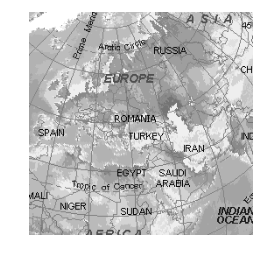

'Globe.pgm space invariant blurred:'

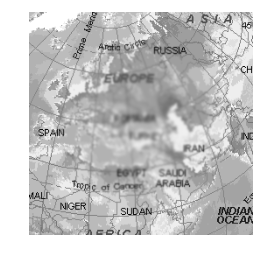

In [42]:
cv2.imwrite('./output/' + globeFile + '-original.pgm', globe)
cv2.imwrite('./output/' + globeFile + '-SV.pgm', globeVariantBlurred)

showImage(globe, 'Globe.pgm original:')
showImage(globeVariantBlurred, 'Globe.pgm space invariant blurred:')


# Code logic for Space variant & Space variant blurring (Nautilus.pgm)

In [43]:
nautilusSigma = np.ones(nautilus.shape)
realSigma = 1.0
nautilusVariantBlurred = doSpaceVariantBlurring(nautilus, nautilusSigma)
nautilusInvariantBlurred = doSpaceInvariantBlurring(nautilus, realSigma)

cv2.imwrite('./output/' + nautilusFile + '-SI.pgm', nautilusInvariantBlurred)
cv2.imwrite('./output/' + nautilusFile + '-SV.pgm', nautilusVariantBlurred)
cv2.imwrite('./output/' + nautilusFile + '-original.pgm', nautilus)
pass

'Original image: '

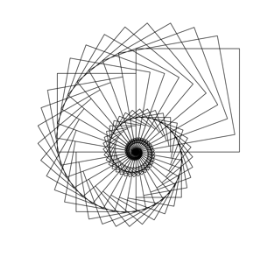

'Spatially invariant blurred image: '

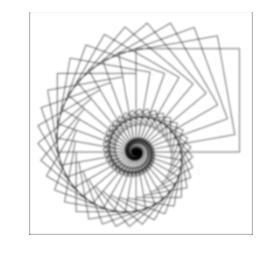

'Spatially invariant blurred image: '

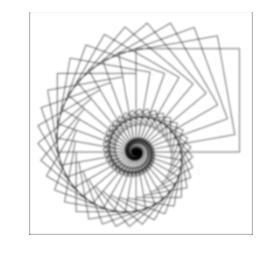

the differeence between the two blurred (SI & SV) images : 
1.82082921324e-11


In [44]:
showImage(nautilus, 'Original image: ')
showImage(nautilusInvariantBlurred, 'Spatially invariant blurred image: ')
showImage(nautilusVariantBlurred, 'Spatially variant blurred image: ')
logger.info('the differeence between the two blurred (SI & SV) images : ')
logger.info(np.linalg.norm(nautilusVariantBlurred - nautilusInvariantBlurred))